# Importing libraries to be used

In [1]:
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd
from pylab import *
import numpy as np

# Jupyter Magics and Settings

In [2]:
%matplotlib inline
# Control the default size of figures
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 9)   # Change the size of plots

Populating the interactive namespace from numpy and matplotlib


C:\Users\sasa9\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['power', 'fft', 'info', 'random', 'linalg']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Creating database engine

**Note:** I will connect to postgres database.

In [3]:
%reload_ext sql_magic
import pandas.io.sql as psql
import psycopg2
connect_credentials = {'database': 'stock',
                       'host': 'localhost',
                       'password': 'disalian',
                       'port': '5432',
                       'user': 'postgres'}

# connect to postgres connection object
conn = psycopg2.connect(**connect_credentials)
conn.autocommit = True
schema_name = 'public'
psql.execute('SET search_path TO {}'.format(schema_name), conn)
%config SQL.conn_name='conn'

# Japanese candlestick plot
This function is to use to more easily create candlestick charts from pandas data frames, and use it to plot our stock data. (Code is based off this [example](http://matplotlib.org/examples/pylab_examples/finance_demo.html), and you can read the [documentation](http://matplotlib.org/examples/pylab_examples/finance_demo.html) for the functions involved here.)

In [4]:
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc

def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines

    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12

    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["open", "high", "low", "close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"open": [], "high": [], "low": [], "close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"open": group.iloc[0,0],
                                            "high": max(group.high),
                                            "low": min(group.low),
                                            "close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365

    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"open": [], "high": [], "low": [], "close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"open": group.iloc[0,0],
                                        "high": max(group.high),
                                        "low": min(group.low),
                                        "close": group.iloc[-1,3]},
                                       index = [group.index[0]]))

    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')


    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)

    ax.grid(True)

    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["open"].tolist(), plotdat["high"].tolist(),
                      plotdat["low"].tolist(), plotdat["close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)

    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)

    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()

In [5]:
%config SQL.output_result=True

I've switched the output result for future queries. You don't have to use this, but it's helpful to know that it exists.

Now that I have my query stored in a variable called test_results, I can use pandas in Python to plot the entire set.

In [6]:
%%read_sql apple
SELECT DATE_TRUNC('day', date) AS date, open, high, low, close, adj_close
FROM information
JOIN company
ON information.company_id = company.id
AND company.name = 'AAPL';

Query started at 07:49:06 AM Egypt Standard Time; Query executed in 0.00 m

,date,open,high,low,close,adj_close
0,1986-03-12,0.444196,0.448661,0.441964,0.441964,0.020108
1,1986-03-13,0.441964,0.446429,0.435268,0.441964,0.020108
2,1986-03-14,0.441964,0.468750,0.441964,0.466518,0.021225
3,1986-03-17,0.464286,0.464286,0.453125,0.464286,0.021123
4,1986-03-18,0.464286,0.486607,0.462054,0.479911,0.021834
5,1986-03-19,0.479911,0.486607,0.470982,0.473214,0.021529
6,1986-03-20,0.500000,0.529018,0.500000,0.504464,0.022951
7,1986-03-21,0.504464,0.513393,0.491071,0.493304,0.022443
8,1986-03-24,0.493304,0.493304,0.470982,0.477679,0.021733
9,1986-03-25,0.477679,0.497768,0.477679,0.497768,0.022647


In [8]:
apple = apple[['open','high','low','close','adj_close']].set_index(apple['date'])
apple.head()

,open,high,low,close,adj_close
date,,,,,
1986-03-12,0.444196,0.448661,0.441964,0.441964,0.020108
1986-03-13,0.441964,0.446429,0.435268,0.441964,0.020108
1986-03-14,0.441964,0.468750,0.441964,0.466518,0.021225
1986-03-17,0.464286,0.464286,0.453125,0.464286,0.021123
1986-03-18,0.464286,0.486607,0.462054,0.479911,0.021834


# Bollinger Bands
The purpose of Bollinger Bands is to provide a relative definition of high and low prices of a market. By definition, prices are high at the upper band and low at the lower band. This definition can aid in rigorous pattern recognition and is useful in comparing price action to the action of indicators to arrive at systematic trading decisions.

It is plotted two standard deviations away from a simple moving average.

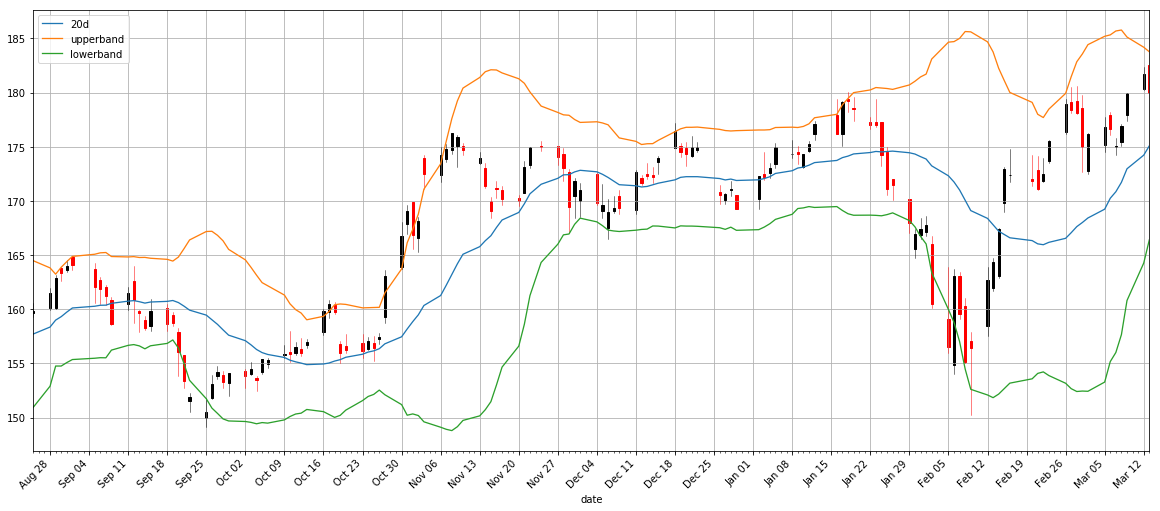

In [10]:
# Compute Bollinger Bands
# 1. Compute rolling mean
apple["20d"] = np.round(apple["close"].rolling(window = 20, center = False).mean(), 2)

# 2. Compute rolling standard deviation
apple_rstd = np.round(apple['close'].rolling(window = 20, center = False).std(), 2)

# 3. Compute upper and lower bands
apple['upperband'] = apple['20d'] + 2 * apple_rstd
apple['lowerband'] = apple['20d'] - 2 * apple_rstd
pandas_candlestick_ohlc(apple.loc['2017-08-25':'2018-03-13',:], otherseries = ["20d", "upperband", "lowerband"])

The price of the stock is bracketed by an upper and lower band along with a 21-day simple moving average. Because standard deviation is a measure of volatility, when the markets become more volatile, the bands widen; during less volatile periods, the bands contract.

Read more: Bollinger Band® https://www.investopedia.com/terms/b/bollingerbands.asp#ixzz5Fjjhb7Yu

## Bollinger Squeeze
When the market becomes too slow and there is a low volatility, the price moves sideways and the Bollinger upper and lower bands become so close to each other. Bollinger Bands Squeeze trade setups are really profitable and have a great risk to reward (R/R) ratio because they show us the beginning of the strong movements and hopefully strong and continued trends.

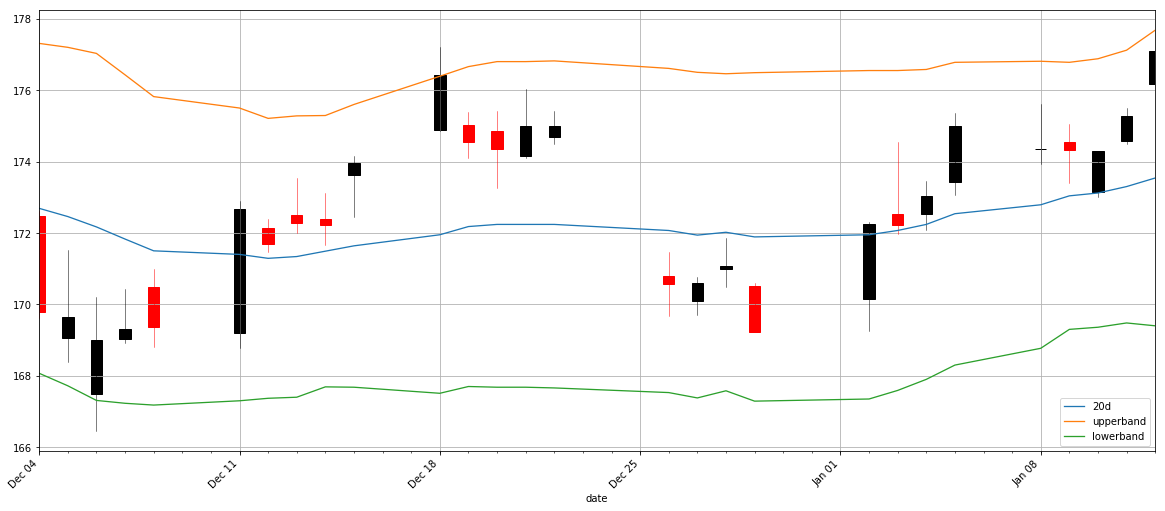

In [12]:
pandas_candlestick_ohlc(apple.loc['2017-12-04':'2018-01-15',:], otherseries = ["20d", "upperband", "lowerband"])

## Bollinger Breakouts

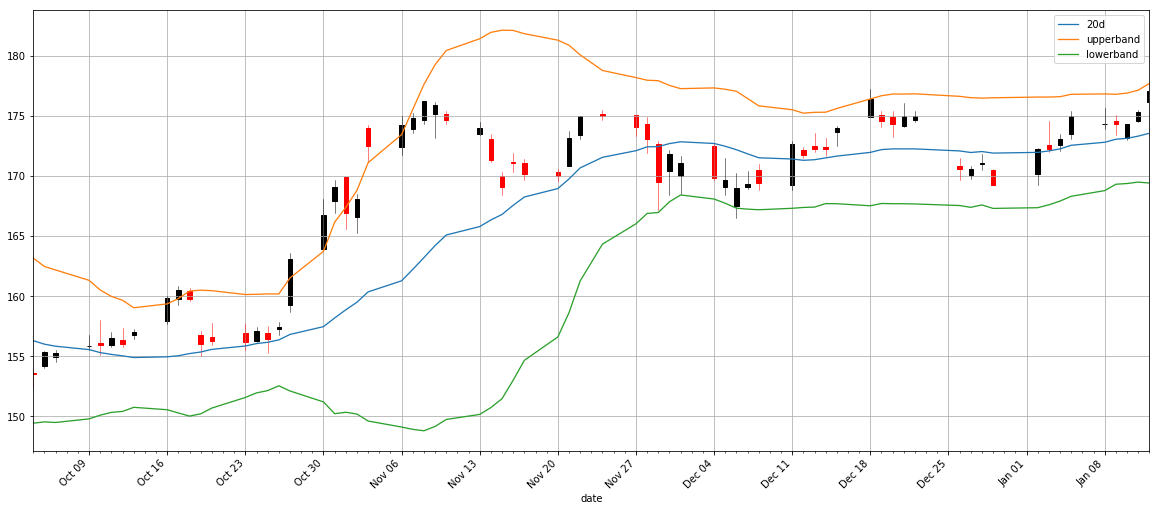

In [14]:
pandas_candlestick_ohlc(apple.loc['2017-10-04':'2018-01-15',:], otherseries = ["20d", "upperband", "lowerband"])